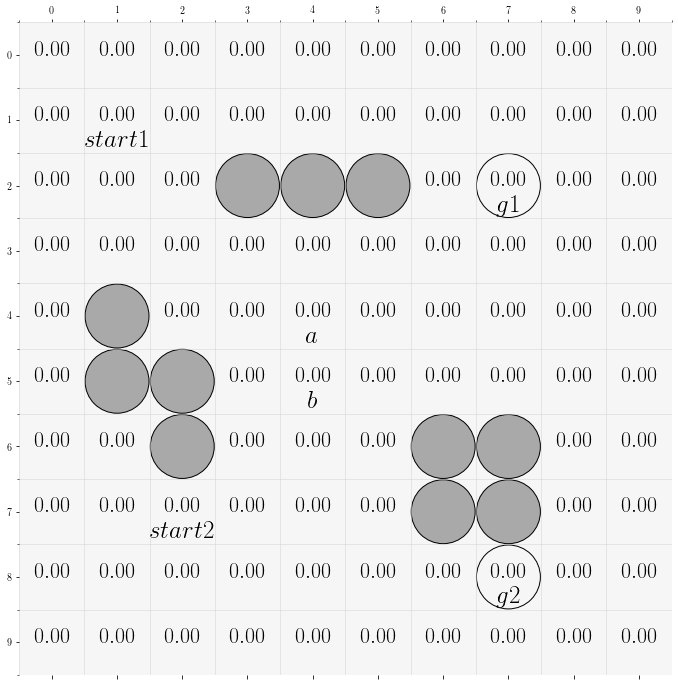

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from csrl.mdp import GridMDP
import numpy as np 
from copy import deepcopy

shape = n_rows, n_cols = (10,10)

structure = np.array([
['E','E','E','E','E','E','E','E','E','E'],
['E','E','E','E','E','E','E','E','E','E'],
['E','E','E','B','B','B','E','T','E','E'],
['E','E','E','E','E','E','E','E','E','E'],
['E','B','E','E','E','E','E','E','E','E'],
['E','B','B','E','E','E','E','E','E','E'],
['E','E','B','E','E','E','B','B','E','E'],
['E','E','E','E','E','E','B','B','E','E'],
['E','E','E','E','E','E','E','T','E','E'],
['E','E','E','E','E','E','E','E','E','E']
])

label = np.empty(shape,dtype=object)
label.fill(())
label[4,4] = ('a',)
label[5,4] = ('b',)
label[1,1] = ('start1',)
label[7,2] = ('start2',)
label[8,7] = ('g2',)
label[2,7] = ('g1',)
    
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,figsize=12, p=0.8)
grid_mdp.plot()

In [11]:
from csrl.oa import OmegaAutomaton

# LTL Specification 
ltl = 'F( (a&b) & XF ( (g1 | XF g1) &  ( g2 | XF g2)) )'
# (!d U b) & F(b & a) & F(b U a) & (FG d)
#  '((Fa & !c) U (a&b))& ((Fb & !d) U (a&b)) & (FG c) & (FG d)'
# '((!c & !d) U F(a & b)) & (FG c) & (FG d)'

# Translate the LTL formula to an LDBA
oa1 = OmegaAutomaton(ltl, extra_aps=grid_mdp.all_labels)

print('Number of Omega-automaton states (including the trap state):',oa1.shape[1])
display(oa1)

Number of Omega-automaton states (including the trap state): 7


In [23]:
oa1.acc

[{(): [None],
  ('a',): [None],
  ('b',): [None],
  ('g1',): [None],
  ('g2',): [None],
  ('start1',): [None],
  ('start2',): [None],
  ('a', 'b'): [None],
  ('a', 'g1'): [None],
  ('a', 'g2'): [None],
  ('a', 'start1'): [None],
  ('a', 'start2'): [None],
  ('b', 'g1'): [None],
  ('b', 'g2'): [None],
  ('b', 'start1'): [None],
  ('b', 'start2'): [None],
  ('g1', 'g2'): [None],
  ('g1', 'start1'): [None],
  ('g1', 'start2'): [None],
  ('g2', 'start1'): [None],
  ('g2', 'start2'): [None],
  ('start1', 'start2'): [None],
  ('a', 'b', 'g1'): [None],
  ('a', 'b', 'g2'): [None],
  ('a', 'b', 'start1'): [None],
  ('a', 'b', 'start2'): [None],
  ('a', 'g1', 'g2'): [None],
  ('a', 'g1', 'start1'): [None],
  ('a', 'g1', 'start2'): [None],
  ('a', 'g2', 'start1'): [None],
  ('a', 'g2', 'start2'): [None],
  ('a', 'start1', 'start2'): [None],
  ('b', 'g1', 'g2'): [None],
  ('b', 'g1', 'start1'): [None],
  ('b', 'g1', 'start2'): [None],
  ('b', 'g2', 'start1'): [None],
  ('b', 'g2', 'start2'): [None

In [12]:
from csrl import ControlSynthesis
import numpy as np 

# Construct product MDPs
csrl1 = ControlSynthesis(grid_mdp,oa1)

csrl2 = ControlSynthesis(grid_mdp,oa1) 

In [89]:
csrl1.A[0][1]

array([[list([0, 1, 2, 3, 6]), list([0, 1, 2, 3, 6]),
        list([0, 1, 2, 3, 6]), list([0, 1, 2, 3, 6])],
       [list([0, 1, 2, 3, 6]), list([0, 1, 2, 3, 6]),
        list([0, 1, 2, 3, 6]), list([0, 1, 2, 3, 6])],
       [list([0, 1, 2, 3, 6]), list([0, 1, 2, 3, 6]),
        list([0, 1, 2, 3, 6]), list([0, 1, 2, 3, 6])],
       [list([0, 1, 2, 3, 6]), list([0, 1, 2, 3, 6]),
        list([0, 1, 2, 3, 6]), list([0, 1, 2, 3, 6])]], dtype=object)

In [13]:
from multi import MultiControlSynthesis

mcsrl = MultiControlSynthesis([csrl1, csrl2], oa = oa1, starts=[(1, 1), (7, 2)], mdp=grid_mdp, sharedoa=True)
mcsrl.shape

(2, 1, 7, 10, 10, 11)

### not shared state -> shared oa -> works but high number of episodes required. -> episodes > 30k 

In [27]:
qval, ep_returns = mcsrl.combined_qlearning(T=350, K=200000)

In [28]:
policies = [np.argmax(qval[0],axis=4), np.argmax(qval[1],axis=4)]
values = [np.max(qval[0],axis=4), np.max(qval[1],axis=4)]

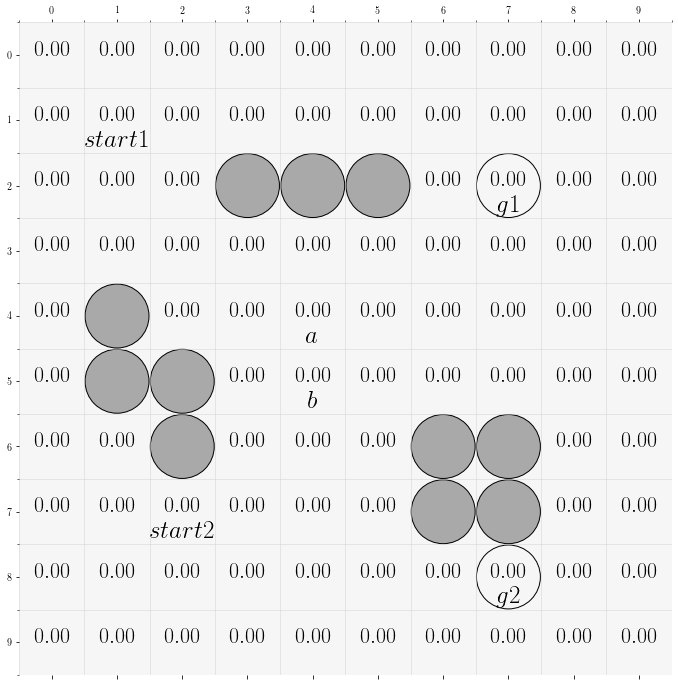

In [7]:
grid_mdp.plot()

In [8]:
#ltl1 = '(!a U b) & F d & FG c'
display(oa1)
mcsrl.plot(0, policies[0], values[0])

interactive(children=(IntSlider(value=0, description='i', max=0), IntSlider(value=0, description='q', max=9), …

In [34]:
mcsrl.plot(1, policies[1], values[1])

interactive(children=(IntSlider(value=0, description='i', max=0), IntSlider(value=0, description='q', max=9), …

In [26]:
policies[0].shape

(1, 7, 4, 8)

In [29]:
ep = mcsrl.simulate(agents = mcsrl.agent_control, policy =policies, T= 30, mdp2 =grid_mdp, animation="sharedoa_bench2")

30
e [[(0, 0, 1, 1), (0, 0, 7, 2)]]
0 :  (0, 1, 1) 	 (0, 7, 2)
1 :  (0, 1, 0) 	 (0, 7, 3)
2 :  (0, 1, 1) 	 (0, 7, 2)
3 :  (0, 2, 1) 	 (0, 7, 3)
4 :  (0, 2, 2) 	 (0, 6, 3)
5 :  (0, 2, 1) 	 (0, 6, 4)
6 :  (0, 2, 2) 	 (0, 5, 4)
7 :  (0, 3, 2) 	 (0, 6, 4)
8 :  (0, 3, 3) 	 (0, 6, 3)
9 :  (0, 4, 3) 	 (0, 6, 4)
10 :  (3, 4, 4) 	 (3, 5, 4)
11 :  (4, 5, 4) 	 (4, 6, 4)
12 :  (4, 4, 4) 	 (4, 6, 5)
13 :  (4, 3, 4) 	 (4, 7, 5)
14 :  (4, 3, 5) 	 (4, 8, 5)
15 :  (4, 3, 6) 	 (4, 8, 6)
16 :  (5, 3, 5) 	 (5, 8, 7)
17 :  (5, 3, 6) 	 (5, 8, 7)
18 :  (5, 3, 7) 	 (5, 8, 7)
19 :  (2, 2, 7) 	 (2, 8, 7)
20 :  (2, 2, 7) 	 (2, 8, 7)
21 :  (2, 2, 7) 	 (2, 8, 7)
22 :  (2, 2, 7) 	 (2, 8, 7)
23 :  (2, 2, 7) 	 (2, 8, 7)
24 :  (2, 2, 7) 	 (2, 8, 7)
25 :  (2, 2, 7) 	 (2, 8, 7)
26 :  (2, 2, 7) 	 (2, 8, 7)
27 :  (2, 2, 7) 	 (2, 8, 7)
28 :  (2, 2, 7) 	 (2, 8, 7)
29 :  (2, 2, 7) 	 (2, 8, 7)


In [170]:
pol = np.argmax(qval[1],axis=4)
pol [0][0]

array([[0, 0, 3, 3],
       [0, 0, 2, 0],
       [0, 0, 0, 3],
       [0, 0, 0, 0]])

In [21]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

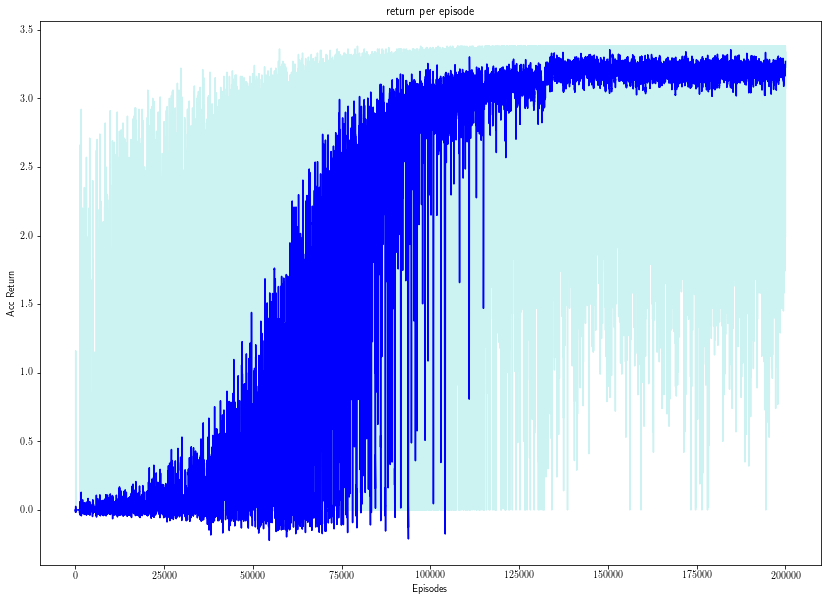

In [30]:
plt.figure(figsize=(14, 10))
plt.plot( ep_returns[:,0], color='c', label='agent 0', alpha=0.2)
yhat = savgol_filter(ep_returns[:,0], 101, 3) # window size 51, polynomial order 3
# yhat2 = savgol_filter(ep_returns[:,1], 101, 3)
plt.plot(yhat, color='b', label='smooth')
# plt.plot(yhat2, color='g', label='smooth2')
# plt.plot(np.arange(0, ep_returns.shape[0]), ep_returns[:,1], color='g',  label='agent 1')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Episodes")
plt.ylabel("Acc Return")
plt.title("return per episode")

np.savetxt('shared_oa_bench2_returns.csv', ep_returns, delimiter=',')

In [3]:
np.arange(0, 10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [88]:
print((mcsrl.Q[1][0]))

[[[[0.         0.         0.         0.         0.         0.
    0.         0.        ]
   [0.         0.         0.         0.         0.         0.
    0.         0.        ]
   [0.00782956 0.00782906 0.007829   0.00782912 0.         0.
    0.         0.        ]
   [0.00783695 0.00783694 0.00783694 0.00783693 0.         0.
    0.         0.        ]]

  [[0.         0.         0.         0.         0.         0.
    0.         0.        ]
   [0.         0.         0.         0.         0.         0.
    0.         0.        ]
   [0.00793691 0.00793678 0.007937   0.00793651 0.         0.
    0.         0.        ]
   [0.00783341 0.00783319 0.00783342 0.00783285 0.         0.
    0.         0.        ]]

  [[0.         0.         0.         0.         0.         0.
    0.         0.        ]
   [0.         0.         0.         0.         0.         0.
    0.         0.        ]
   [0.00771174 0.00357202 0.0052338  0.00335323 0.         0.
    0.         0.        ]
   [0.00508919 0.

In [116]:
p = np.max(qval[1], axis=4)
print(qval[1][0][3][3])

[[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [126.87881441 126.87881498 126.87881509 126.87881467   0.
    0.           0.           0.          33.21196389   0.        ]
 [126.87884028 126.87884155 126.87884157 126.8788405    0.
    0.           0.           0.           0.           0.        ]]


In [83]:
csrl2.A[0][3]

array([[list([0, 1, 2, 3]), list([0, 1, 2, 3]), list([0, 1, 2, 3]),
        list([0, 1, 2, 3])],
       [list([0, 1, 2, 3]), list([0, 1, 2, 3]), list([0, 1, 2, 3]),
        list([0, 1, 2, 3])],
       [list([0, 1, 2, 3]), list([0, 1, 2, 3]), list([0, 1, 2, 3]),
        list([0, 1, 2, 3])],
       [list([0, 1, 2, 3]), list([0, 1, 2, 3]), list([0, 1, 2, 3]),
        list([0, 1, 2, 3])]], dtype=object)

In [84]:
csrl2.reward

array([[[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]]])

## Debug

In [10]:
from csrl.oa import OmegaAutomaton

# LTL Specification 
ltl2 = 'F( (a&b) & XF ( (g1 | XF g1) &  ( g2 | XF g2)) )'

#'F( F(a &b) & ( F( g1 | XF g1) &  F( g2 | XF g2)))'

# (!d U b) & F(b & a) & F(b U a) & (FG d)
#  '((Fa & !c) U (a&b))& ((Fb & !d) U (a&b)) & (FG c) & (FG d)'
# '((!c & !d) U F(a & b)) & (FG c) & (FG d)'

# Translate the LTL formula to an LDBA
oa2 = OmegaAutomaton(ltl2, extra_aps=grid_mdp.all_labels)

print('Number of Omega-automaton states (including the trap state):',oa2.shape[1])
display(oa2)

Number of Omega-automaton states (including the trap state): 7
